In [1]:
pip install ucimlrepo

In [65]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [66]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns


In [67]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Grab the names of categorical, numerical, categorical but cardinal, and numerical but categorical columns from a dataframe.

    Parameters:
    dataframe (pd.DataFrame): The dataframe containing the data.
    cat_th (int): Threshold for considering numerical columns as categorical (default: 10).
    car_th (int): Threshold for considering categorical columns as cardinal (default: 20).

    Returns:
    tuple: A tuple containing the lists of categorical columns, numerical columns, and categorical but cardinal columns.
    """
    
    # Categorical columns (including object and categories with less than 'cat_th' unique values)
    cat_cols = [col for col in dataframe.columns if (dataframe[col].dtype == "O" )]
    
    # Numerical columns but actually categorical based on 'cat_th'
    num_but_cat = [col for col in dataframe.select_dtypes(include=["int64", "float64"]).columns 
                   if dataframe[col].nunique() < cat_th]
    
    # Categorical but cardinal (having unique values greater than 'car_th')
    cat_but_car = [col for col in dataframe.columns 
                   if dataframe[col].nunique() > car_th and dataframe[col].dtype == "O"]
    
    # Update cat_cols by adding numerical but categorical columns
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]  # Exclude cardinal columns
    
    # Numerical columns
    num_cols = [col for col in dataframe.select_dtypes(include=["int64", "float64"]).columns 
                if col not in num_but_cat]
    
    # Printing summary
    print(f"Data Overview:\n{'-'*50}")
    print(f"Total Observations: {dataframe.shape[0]}")
    print(f"Total Variables: {dataframe.shape[1]}")
    print(f'Categorical Columns: {len(cat_cols)} -> {cat_cols}')
    print(f'Numerical Columns: {len(num_cols)} -> {num_cols}')
    print(f'Categorical but Cardinal Columns: {len(cat_but_car)} -> {cat_but_car}')
    print(f'Numerical but Categorical Columns: {len(num_but_cat)} -> {num_but_cat}')
    print(f"{'-'*50}")
    
    return cat_cols, num_cols, cat_but_car


In [68]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

In [109]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")




def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

In [70]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
census_income = fetch_ucirepo(id=20) 
  
# data (as pandas dataframes) 
X = census_income.data.features 
y = census_income.data.targets 
  
# metadata 
print(census_income.metadata) 
  
# variable information 
print(census_income.variables) 
df = pd.concat([X, y], axis=1)

{'uci_id': 20, 'name': 'Census Income', 'repository_url': 'https://archive.ics.uci.edu/dataset/20/census+income', 'data_url': 'https://archive.ics.uci.edu/static/public/20/data.csv', 'abstract': 'Predict whether income exceeds $50K/yr based on census data.  Also known as Adult dataset.', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Mon Sep 09 2024', 'dataset_doi': '10.24432/C5GP7S', 'creators': ['Ron Kohavi'], 'intro_paper': None, 'additional_info': {'summary': 'Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && 

In [71]:
print(y.value_counts())

income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: count, dtype: int64


In [72]:
df["cleaned_income"] = df["income"].str.replace(".","",regex=False)
df["cleaned_income"] = df["cleaned_income"].apply(lambda x: 1 if x == ">50K" else 0)

In [73]:
print(df["cleaned_income"].value_counts(normalize=True))

cleaned_income
0    0.760718
1    0.239282
Name: proportion, dtype: float64


In [74]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income', 'cleaned_income'],
      dtype='object')

In [75]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Data Overview:
--------------------------------------------------
Total Observations: 48842
Total Variables: 16
Categorical Columns: 9 -> ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'income', 'cleaned_income']
Numerical Columns: 6 -> ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical but Cardinal Columns: 1 -> ['native-country']
Numerical but Categorical Columns: 1 -> ['cleaned_income']
--------------------------------------------------


In [76]:
missing_values_table(df)

                n_miss  ratio
occupation         966   1.98
workclass          963   1.97
native-country     274   0.56


In [77]:
df = df.dropna()

In [78]:
df.isnull().any()

age               False
workclass         False
fnlwgt            False
education         False
education-num     False
marital-status    False
occupation        False
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
native-country    False
income            False
cleaned_income    False
dtype: bool

In [79]:
for column in num_cols:
    print(column,check_outlier(df,column))

age True
fnlwgt True
education-num True
capital-gain True
capital-loss True
hours-per-week True


In [80]:
for column in num_cols:
    print(column,outlier_thresholds(df,column))

age (-2.0, 78.0)
fnlwgt (-62620.0, 417924.0)
education-num (4.5, 16.5)
capital-gain (0.0, 0.0)
capital-loss (0.0, 0.0)
hours-per-week (32.5, 52.5)


In [81]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,cleaned_income
count,47621.000000,4.762100e+04,47621.000000,47621.000000,47621.000000,47621.000000,47621.000000
mean,38.640684,1.897271e+05,10.090821,1091.137649,87.853489,40.600050,0.242351
std,13.558961,1.055695e+05,2.568320,7487.228336,404.010612,12.260345,0.428510
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.175840e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.782820e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.377200e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


In [82]:
for column in cat_cols:
    print(cat_summary(df,column))

                  workclass      Ratio
workclass                             
Private               33717  70.802797
Self-emp-not-inc       3838   8.059470
Local-gov              3126   6.564331
State-gov              1965   4.126331
?                      1836   3.855442
Self-emp-inc           1688   3.544655
Federal-gov            1423   2.988177
Without-pay              21   0.044098
Never-worked              7   0.014699
##########################################
None
              education      Ratio
education                         
HS-grad           15444  32.431070
Some-college      10512  22.074295
Bachelors          7881  16.549421
Masters            2610   5.480775
Assoc-voc          2034   4.271225
11th               1746   3.666450
Assoc-acdm         1566   3.288465
10th               1336   2.805485
7th-8th             912   1.915121
Prof-school         819   1.719829
9th                 735   1.543437
12th                633   1.329246
Doctorate           582   1.22215

In [83]:
rare_analyser(df,"cleaned_income",cat_cols)

workclass : 9
                  COUNT     RATIO  TARGET_MEAN
workclass                                     
?                  1836  0.038554     0.104031
Federal-gov        1423  0.029882     0.390021
Local-gov          3126  0.065643     0.295266
Never-worked          7  0.000147     0.000000
Private           33717  0.708028     0.217635
Self-emp-inc       1688  0.035447     0.553318
Self-emp-not-inc   3838  0.080595     0.278530
State-gov          1965  0.041263     0.269211
Without-pay          21  0.000441     0.095238


education : 16
              COUNT     RATIO  TARGET_MEAN
education                                 
10th           1336  0.028055     0.063623
11th           1746  0.036664     0.051546
12th            633  0.013292     0.074250
1st-4th         239  0.005019     0.033473
5th-6th         494  0.010374     0.052632
7th-8th         912  0.019151     0.065789
9th             735  0.015434     0.054422
Assoc-acdm     1566  0.032885     0.259898
Assoc-voc      2034  0

In [84]:
education_mapping = {
    '10th': 'School',
    '11th': 'School',
    '12th': 'School',
    '1st-4th': 'Primary',
    '5th-6th': 'Primary',
    '7th-8th': 'School',
    '9th': 'School',
    'Assoc-acdm': 'College',
    'Assoc-voc': 'College',
    'Bachelors': 'University',
    'Doctorate': 'Post-Graduate',
    'HS-grad': 'School',
    'Masters': 'Post-Graduate',
    'Preschool': 'Pre-School',
    'Prof-school': 'Post-Graduate',
    'Some-college': 'College'
}

df['education'] = df['education'].replace(education_mapping)

In [85]:
workclass_mapping = {
    'Never-worked': 'Unemployed',
    'Without-pay': 'Unemployed'
}


df['workclass'] = df['workclass'].replace(workclass_mapping)

In [86]:
rare_analyser(df,"cleaned_income",cat_cols)

workclass : 8
                  COUNT     RATIO  TARGET_MEAN
workclass                                     
?                  1836  0.038554     0.104031
Federal-gov        1423  0.029882     0.390021
Local-gov          3126  0.065643     0.295266
Private           33717  0.708028     0.217635
Self-emp-inc       1688  0.035447     0.553318
Self-emp-not-inc   3838  0.080595     0.278530
State-gov          1965  0.041263     0.269211
Unemployed           28  0.000588     0.071429


education : 6
               COUNT     RATIO  TARGET_MEAN
education                                  
College        14112  0.296340     0.210388
Post-Graduate   4011  0.084228     0.615308
Pre-School        78  0.001638     0.012821
Primary          733  0.015392     0.046385
School         20806  0.436908     0.134384
University      7881  0.165494     0.415303


marital-status : 7
                       COUNT     RATIO  TARGET_MEAN
marital-status                                     
Divorced               

In [87]:
df['age_group'] = pd.cut(df['age'], bins=[17, 29,53,71,90], 
                         labels=['17-29', '30-53', '54-71', '72-90'])
df['age_group'] = df['age_group'].astype("object")

In [88]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
cat_cols = [col for col in cat_cols if col != "cleaned_income"]
y = df["cleaned_income"]

Data Overview:
--------------------------------------------------
Total Observations: 47621
Total Variables: 17
Categorical Columns: 10 -> ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'income', 'age_group', 'cleaned_income']
Numerical Columns: 6 -> ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical but Cardinal Columns: 1 -> ['native-country']
Numerical but Categorical Columns: 1 -> ['cleaned_income']
--------------------------------------------------


In [89]:
df = pd.get_dummies(df[cat_cols] , drop_first = True)

In [90]:
df.columns

Index(['workclass_Federal-gov', 'workclass_Local-gov', 'workclass_Private',
       'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc',
       'workclass_State-gov', 'workclass_Unemployed',
       'education_Post-Graduate', 'education_Pre-School', 'education_Primary',
       'education_School', 'education_University',
       'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       '

In [91]:
df = df.drop(['income_<=50K.', 'income_>50K', 'income_>50K.'],axis=1)

In [92]:
df.columns

Index(['workclass_Federal-gov', 'workclass_Local-gov', 'workclass_Private',
       'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc',
       'workclass_State-gov', 'workclass_Unemployed',
       'education_Post-Graduate', 'education_Pre-School', 'education_Primary',
       'education_School', 'education_University',
       'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       '

In [96]:
x = df
rf = RandomForestClassifier()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
rf.fit(x_train,y_train)

RandomForestClassifier()

In [97]:
print("Test Accuracy : ",rf.score(x_test,y_test))
print("Train Accuracy : ",rf.score(x_train,y_train))

Test Accuracy :  0.8222572178477691
Train Accuracy :  0.8594078118437631


In [99]:
test_accuracy = []
train_accuracy = []
depths = range(1,30)
for i in depths:
    rf_temporay = RandomForestClassifier(max_depth = i)
    rf_temporay.fit(x_train,y_train)
    test_accuracy.append(rf_temporay.score(x_test,y_test))
    train_accuracy.append(rf_temporay.score(x_train,y_train))    

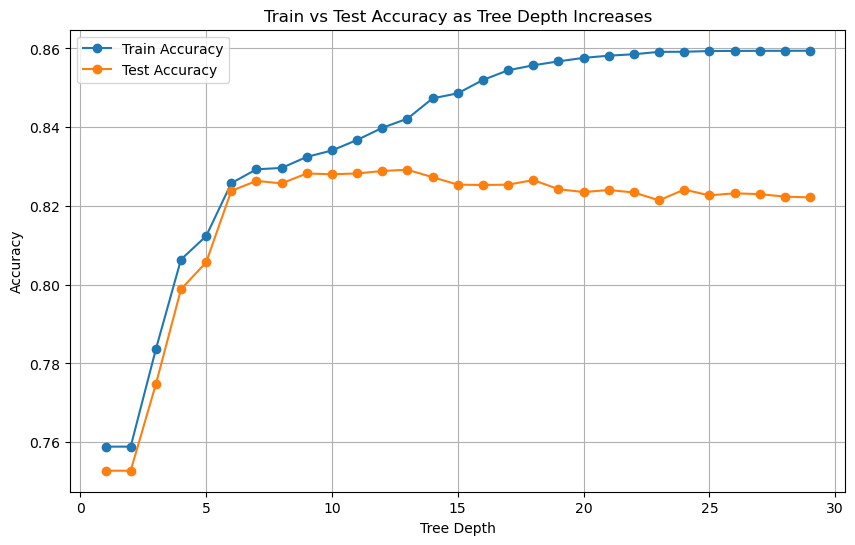

In [105]:
plt.figure(figsize=(10,6)) 
plt.plot(depths, train_accuracy, label="Train Accuracy", marker='o') 
plt.plot(depths, test_accuracy, label="Test Accuracy", marker='o')    
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy as Tree Depth Increases')
plt.legend()  
plt.grid(True)  
plt.show()  


In [108]:
best_accuracy = np.max(test_accuracy)
best_depth = np.argmax(test_accuracy)
print("Best accuracy : ",best_accuracy)
print("Best depth : ",best_depth)

Best accuracy :  0.8291863517060367
Best depth :  12


In [110]:
best_rf = RandomForestClassifier(max_depth=best_depth)
best_rf.fit(x_train,y_train)

RandomForestClassifier(max_depth=12)

In [111]:
print(best_rf.score(x_test,y_test))

0.8292913385826771


In [123]:
feature_table = pd.DataFrame({'Feature': df.columns,  'Importance': best_rf.feature_importances_}).sort_values(by="Importance",ascending=False)


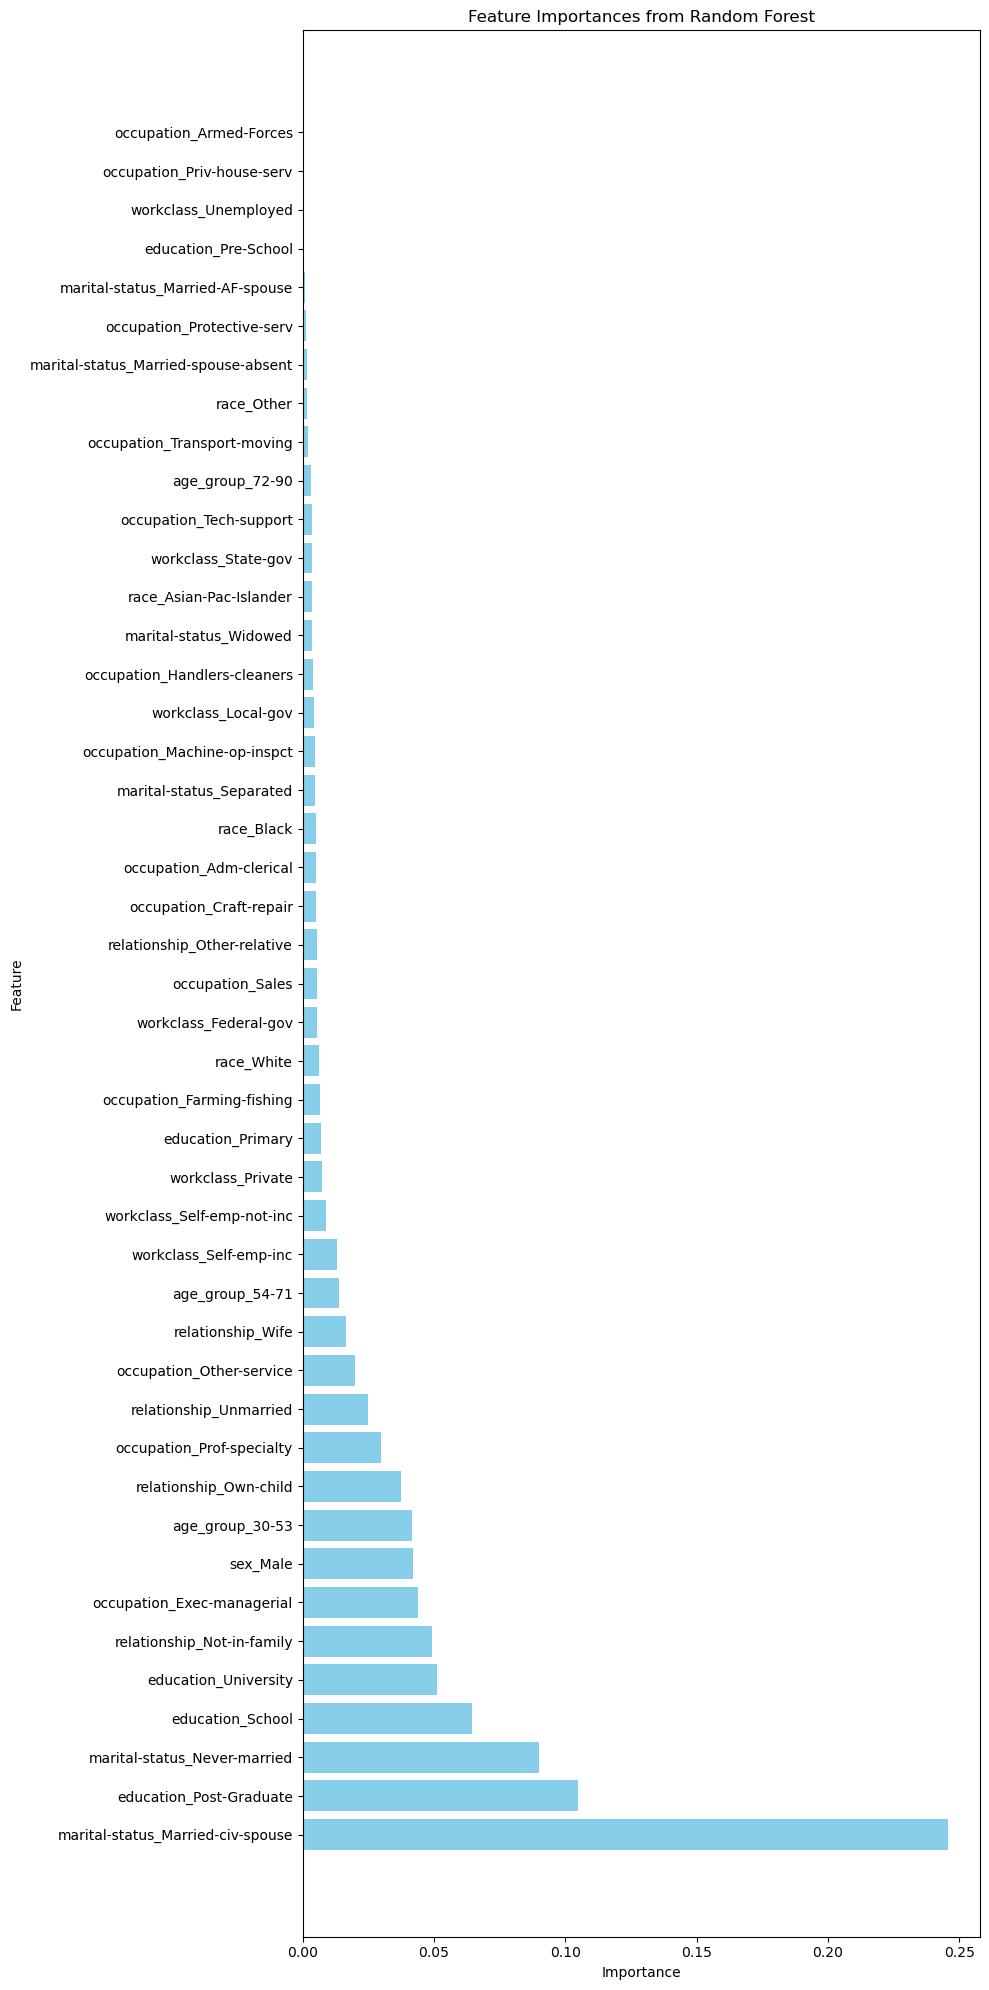

In [134]:
plt.figure(figsize=(10,20))
plt.barh(feature_table['Feature'], feature_table['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.tight_layout()  
plt.show()

In [131]:
print(feature_table)

                                 Feature  Importance
13     marital-status_Married-civ-spouse    0.245637
7                education_Post-Graduate    0.104925
15          marital-status_Never-married    0.090139
10                      education_School    0.064575
11                  education_University    0.051184
32            relationship_Not-in-family    0.049243
21            occupation_Exec-managerial    0.043978
41                              sex_Male    0.041860
42                       age_group_30-53    0.041509
34                relationship_Own-child    0.037534
27             occupation_Prof-specialty    0.029972
35                relationship_Unmarried    0.024760
25              occupation_Other-service    0.019933
36                     relationship_Wife    0.016485
43                       age_group_54-71    0.013928
3                 workclass_Self-emp-inc    0.013056
4             workclass_Self-emp-not-inc    0.008982
2                      workclass_Private    0.